<a href="https://colab.research.google.com/github/Federico6419/MachineLearningProject/blob/main/Q-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install libraries


In [1]:
!pip install gymnasium              #Install Gymnasium
!pip install swig                   #This solves the error in the installation of gymnasium[box2d]
!pip install gymnasium[box2d]       #Install Box2D
!pip install gym-notebook-wrapper   #This installs Gym-Notebook-Wrapper, that provides small wrappers for running and rendering OpenAI Gym

#To solve the xvfb missing file problem
!sudo apt-get install xvfb
!pip install xvfbwrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373077 sha256=a3ce441e106769460758eec852d70b053d316b3af03da1d3830a8c5e6a35ba5e
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkb

## Import libraries

In [2]:
!git clone https://github.com/Federico6419/MachineLearningProject               #It clones my github repository
%cd MachineLearningProject

import gymnasium as gym
import gnwrapper
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
import config
from model import Model
from collections import deque
from torchvision import transforms
import base64
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")           #Select the Device

Cloning into 'MachineLearningProject'...
remote: Enumerating objects: 477, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 477 (delta 35), reused 6 (delta 6), pack-reused 409
Receiving objects: 100% (477/477), 5.08 MiB | 9.47 MiB/s, done.
Resolving deltas: 100% (284/284), done.
/content/MachineLearningProject


#Training

In [3]:
#Manage Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Initialize the Variables
episode_reward = 0                                 #This is the Variable in which it will be stored the Reward of each Episode
tot_negative_reward = 0                            #This Variable counts the number of consecutive Negative Rewards
time_frame_counter = 1                             #This is the Counter of the Frames
buffer = deque([], config.BUFFER_SIZE)             #Initialize the Queue that contains the past experience
epsilon = config.MAX_EPSILON
if(config.LOAD_CHECKPOINT):                        #If Checkpoints are loaded, initialize Epsilon to a specific value
    epsilon = config.LOADED_EPSILON

alpha = config.ALPHA
decay = config.EPSILON_DECAY

#Array that will store the Rewards
cum_reward_table = np.zeros(config.NUM_EPISODES)
cum_reward_nn = np.zeros(config.NUM_EPISODES)

#Initialize the Model
model = Model().to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config.LR)

#If Checkpoints are loaded, load them on the Models
if(config.LOAD_CHECKPOINT):
    config.load_model(config.LOAD_CHECKPOINT_FOLDER,model,optimizer)

#Initialize the Mean Squared Error Loss
mean_squared_error = torch.nn.MSELoss()

#Define the Action Space, that is composed by 12 Actions of type (Steering Wheel, Throttle, Break)
action_space = [
                (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2),
                (-1, 1,   0), (0, 1,   0), (1, 1,   0),
                (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2),
                (-1, 0,   0), (0, 0,   0), (1, 0,   0)
              ]


#Here it follow the definition of the Functions that contain the Policy to choose the Action to perform

#Q-Table Policy
def select_action(state, epsilon):
    rv = random.uniform(0, 1)
    if rv < epsilon:
        return action_space[random.randrange(len(action_space))]          #Sample a random action from the Action Space
    else:
        if state in Q_Table:
            return action_space[np.argmax(Q_Table[state])]                #Return the action with the highest value for the current state in the Q-Table
        else:
            return (0, 1, 0)

#Neural Network Policy
def select_action_nn(state, epsilon):
    rv = random.uniform(0, 1)
    if rv < epsilon:
        return action_space[random.randrange(len(action_space))]          #We sample a random action from the Action Space

    else:
        prediction = model(torch.from_numpy(state.astype('float32')).to(config.DEVICE)).detach().cpu().numpy()
        action = action_space[np.argmax(prediction)]                      #Select the action with the maximum predicted value
        return action


#Here it follow the definition of the Functions that update the value of Epsilon

#Update Epsilon in each iteration until it converges to MIN_EPSILON
def update_epsilon(epsilon):
    epsilon -= epsilon/100          #Let's reduce the value of Epsilon by 1/100
    if epsilon <= config.MIN_EPSILON:
        return config.MIN_EPSILON
    else:
        return epsilon

#Update Epsilon in each episode multiplying it by the Decay
def update_epsilon_nn(epsilon):
    epsilon *= decay
    if epsilon <= config.MIN_EPSILON:
        return config.MIN_EPSILON
    else:
        return epsilon


#This is the function that discretizes the image
def discretize_image(image):
    image = image.unsqueeze(0)

    #Execute the 3x3 Average Pooling
    pooling = nn.AvgPool2d(8, stride=8)
    image = pooling(image)
    image = image.squeeze(0)

    #Create the image identifier
    string = "S"
    for i, x in enumerate(image.numpy()):
        for j in x:
            if(j < 30):
                string = string + "0"
            elif(j < 60):
                string = string + "1"
            elif(j < 90):
                string = string + "2"
            elif(j < 120):
                string = string + "3"
            elif(j < 150):
                string = string + "4"
            elif(j < 180):
                string = string + "5"
            elif(j < 210):
                string = string + "6"
            elif(j < 256):
                string = string + "7"

    return string


#Initialize the Car Racing Environment
env = gym.make("CarRacing-v2", render_mode="human")


#Q Table
if(config.USE_QTABLE):
    #Initialize the Q-Table as a Dictionary
    Q_Table = {}

    for i in range(config.NUM_EPISODES):              #Iterate over the Episodes
        state, info = env.reset()               #The state is a 96x96 Matrix

        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)           #Convert the state into a Grayscale Image

        #Discretize the image
        state = torch.from_numpy(state.astype('float32'))
        state = discretize_image(state)

        done = False
        j = 0

        while(True):                    #Iterate over the Steps
            action = select_action(state, epsilon)                                #Select the action to perform
            observation, reward, done, truncated, info = env.step(action)         #Execute one step with the chosen action
            observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)           #Convert the state into a Grayscale Image
            image = torch.from_numpy(observation.astype('float32'))
            next_state = discretize_image(image)                                  #Discretize the current state

            #If the following state is inside the Q-Table, take the maximum among the values of its entry in the dictionary
            if next_state in Q_Table:
                next_max = np.max(Q_Table[next_state])
            else:
                next_max = 0

            #Apply the Q-Learning Formula to update the Q-Table entry of the current state and action
            if state in Q_Table:
                Q_Table[state][action_space.index(action)] += alpha * (reward + config.GAMMA * next_max - Q_Table[state][action_space.index(action)])
            else:
                Q_Table[state] = [0] * 12
                Q_Table[state][action_space.index(action)] += alpha * (reward + config.GAMMA * next_max - Q_Table[state][action_space.index(action)])

            state = next_state

            #If we obtain more than 25 consecutive negative reward, we'll terminate the current episode
            tot_negative_reward = tot_negative_reward + 1 if time_frame_counter > 100 and reward < 0 else 0

            #Increment the Reward if the current Action has the maximum value for the Throttle and the minimum value fot the Break
            if action[1] == 1 and action[2] == 0:
                reward *= 1.5

            episode_reward += reward
            if j % 4 == 0:
                time_frame_counter += 1         #Update the counter of the Frames
            j += 1

            #Stop iterating if the current episode is finished, truncated, it has a negative cumulative reward or it has 25 consecutive negative rewards
            if done or truncated or tot_negative_reward > 25 or episode_reward < 0:
                epsilon = update_epsilon_nn(epsilon)            #Update the value of Epsilon
                print("Current Episode: ", i)
                print("Cumulative reward: ", episode_reward)
                print("Current epsilon: ", epsilon)
                print("\n")
                epsilon = update_epsilon(epsilon)
                cum_reward_table[i]=episode_reward
                episode_reward = 0      #Reset the total reward for each episode
                tot_negative_reward = 1
                time_frame_counter = 1
                break


        with open("QTable.csv", "w") as outfile:
            writer = csv.writer(outfile)      #Pass the csv file to csv.writer
            writer.writerow(Q_Table.keys())
            key_list = list(Q_Table.keys())
            #Let's now iterate on each column and assign the corresponding values to the column
            for i in range(12):
                writer.writerow([Q_Table[x][i] for x in key_list])
            !cp QTable.csv "../drive/My Drive/"


#Use a Neural Network to approximate the Q-Function
else:
    for i in range(config.NUM_EPISODES):            #Iterate over the Episodes
        state, info = env.reset()                                 #The state is a 96x96 Matrix
        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)           #Convert the state into a Grayscale Image, that is a Matrix 96x96 composed by Integer values

        frames_queue = deque([state]*3, maxlen = 3)               #Add the initial state into the Queue

        done = False

        while(True):                    #Iterate over the Steps

            current_frame = np.array(frames_queue)

            action = select_action_nn(current_frame, epsilon)         #Select the aAction with the maximum predicted Q-Value
                                                                      #The Action is composed by 3 Values, that are the steering wheel, gas and breaking

            rew = 0
            #Skip 3 Frames
            for tot in range(3):
                next_state, reward, done, truncated, info = env.step(action)
                rew += reward
                if done or truncated:
                    break

            #If we obtain more than 25 consecutive negative reward, we'll terminate the current episode
            tot_negative_reward = tot_negative_reward + 1 if time_frame_counter > 100 and reward < 0 else 0


            #Increment the Reward if the current Action has the maximum value for the Throttle and the minimum value fot the Break
            if action[1] == 1 and action[2] == 0:
                rew *= 1.5

            episode_reward += rew               #Update the cumulative episode reward

            next_state = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)           #Convert the next state into a Grayscale Image

            frames_queue.append(next_state)                                     #Append the next state to the Queue
            next_frame = np.array(frames_queue)

            #Remove the oldest item if the queue is full, in a way such that we can add a new one
            if len(buffer)>=config.BUFFER_SIZE:
                buffer.popleft()               #We dequeue the oldest item

            buffer.append((current_frame, action_space.index(action), reward, next_frame, done))

            #Stop iterating if the current episode is finished, truncated, it has a negative cumulative reward or it has 25 consecutive negative rewards
            if done or truncated or tot_negative_reward > 25 or episode_reward < 0:
                epsilon = update_epsilon_nn(epsilon)            #Update the value of Epsilon
                print("Current Episode: ", i)
                print("Cumulative reward: ", episode_reward)
                print("Current epsilon: ", epsilon)
                print("\n")
                break

            #Let's train the Neural Network every 4 actions and if the buffer has at least BATCH_SIZE elements
            if(len(buffer) >= config.BATCH_SIZE):
                batch = random.sample(buffer, config.BATCH_SIZE)                #Shuffle randomly the elements of the Buffer

                output_array = []                 #This array will contain the predictions made by the Model with respect to the current Action
                target_array = []                 #This array will contain the Rewards updated summing the prediction made by the Target Model (Using the Bellman's Equation)

                #Iterate over the shuffled elements of the Buffer
                for current_frame, action, reward, next_frame, done in batch:

                    #Use the Model to compute the prediction over the next frame
                    next_frame = torch.from_numpy(next_frame.astype('float32')).to(config.DEVICE)
                    next_frame = model(next_frame)

                    #Compute the Target using the Bellman's Equation
                    target = reward + (1 - done) * config.GAMMA * max(next_frame)

                    #Append the Target to the Target Array
                    target_array.append(target)

                    #Use the Model to compute the prediction over the current frame
                    current_frame = torch.from_numpy(current_frame.astype('float32')).to(config.DEVICE)
                    output = model(current_frame)

                    #Append the prediction of the current Action to the Output Array
                    output_array.append(output[action])

                #Stack the two Arrays
                output_array = torch.stack(output_array)
                target_array = torch.stack(target_array)

                #Compute the Mean Squared Error Loss
                loss = mean_squared_error(output_array, target_array)

                optimizer.zero_grad()                   #Reset the Gradients
                loss.backward()                         #Execute the Backpropagation of the Loss
                optimizer.step()                        #Update the weights

            time_frame_counter += 1         #Update the counter of the Frames


        #Save the weights of the Network every 5 Episodes
        if (i+1) % 5 == 0:
            config.save_model(model, optimizer, i+1)

            #Save the Weights also on Google Drive
            torch.save({
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }, "../drive/MyDrive/Checkpoint/" + str(i))

            print("Weigths saved in: "+ config.CHECKPOINT_FOLDER)


        cum_reward_nn[i] = episode_reward                     #Add the current episode's reward to the array

        #Reset the Variables
        episode_reward = 0
        tot_negative_reward = 1
        time_frame_counter = 1


#Close the Environment
env.close()


#Results plotting

episodes = np.zeros(config.NUM_EPISODES, int)
for i in range (config.NUM_EPISODES):
    episodes[i] = i

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
if(config.USE_QTABLE):
    ax.plot(episodes, cum_reward_table)
else:
    ax.plot(episodes, cum_reward_nn)
ax.set_xlabel('EPISODES', fontsize=14)  # Add an x-label to the axes.
ax.set_ylabel('CUMULATIVE REWARD', fontsize=14)  # Add a y-label to the axes.
ax.set_title("TRAINING", fontsize=18)  # Add a title to the axes.
#ax.legend(loc=(0.3, -0.1))  # Add a legend.

plt.xticks(np.arange(0, 500, 50))            # np.arange(min,max, step)

#Save the image of plotting
plt.savefig('TrainingPlot.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive
Current Episode:  0
Cumulative reward:  25.511016949152282
Current epsilon:  0.99


Current Episode:  1
Cumulative reward:  -0.12745098039219493
Current epsilon:  0.9801


Current Episode:  2
Cumulative reward:  0.060606060605969514
Current epsilon:  0.9702989999999999


Current Episode:  3
Cumulative reward:  21.66791530944578
Current epsilon:  0.96059601


Current Episode:  4
Cumulative reward:  31.826271186440337
Current epsilon:  0.9509900498999999


Weigths saved in: Checkpoints/checkpoint.pth.tar
Current Episode:  5
Cumulative reward:  26.73006993006966
Current epsilon:  0.9414801494009999


Current Episode:  6
Cumulative reward:  12.79452054794505
Current epsilon:  0.9320653479069899


Current Episode:  7
Cumulative reward:  8.479211469533825
Current epsilon:  0.92274469442792


Current Episode:  8
Cumulative reward:  35.321739130434494
Current epsilon:  0.9135172474836407


Current Episode:  9
Cumulative reward:  31.213768115941598
Current epsilon:  0.

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


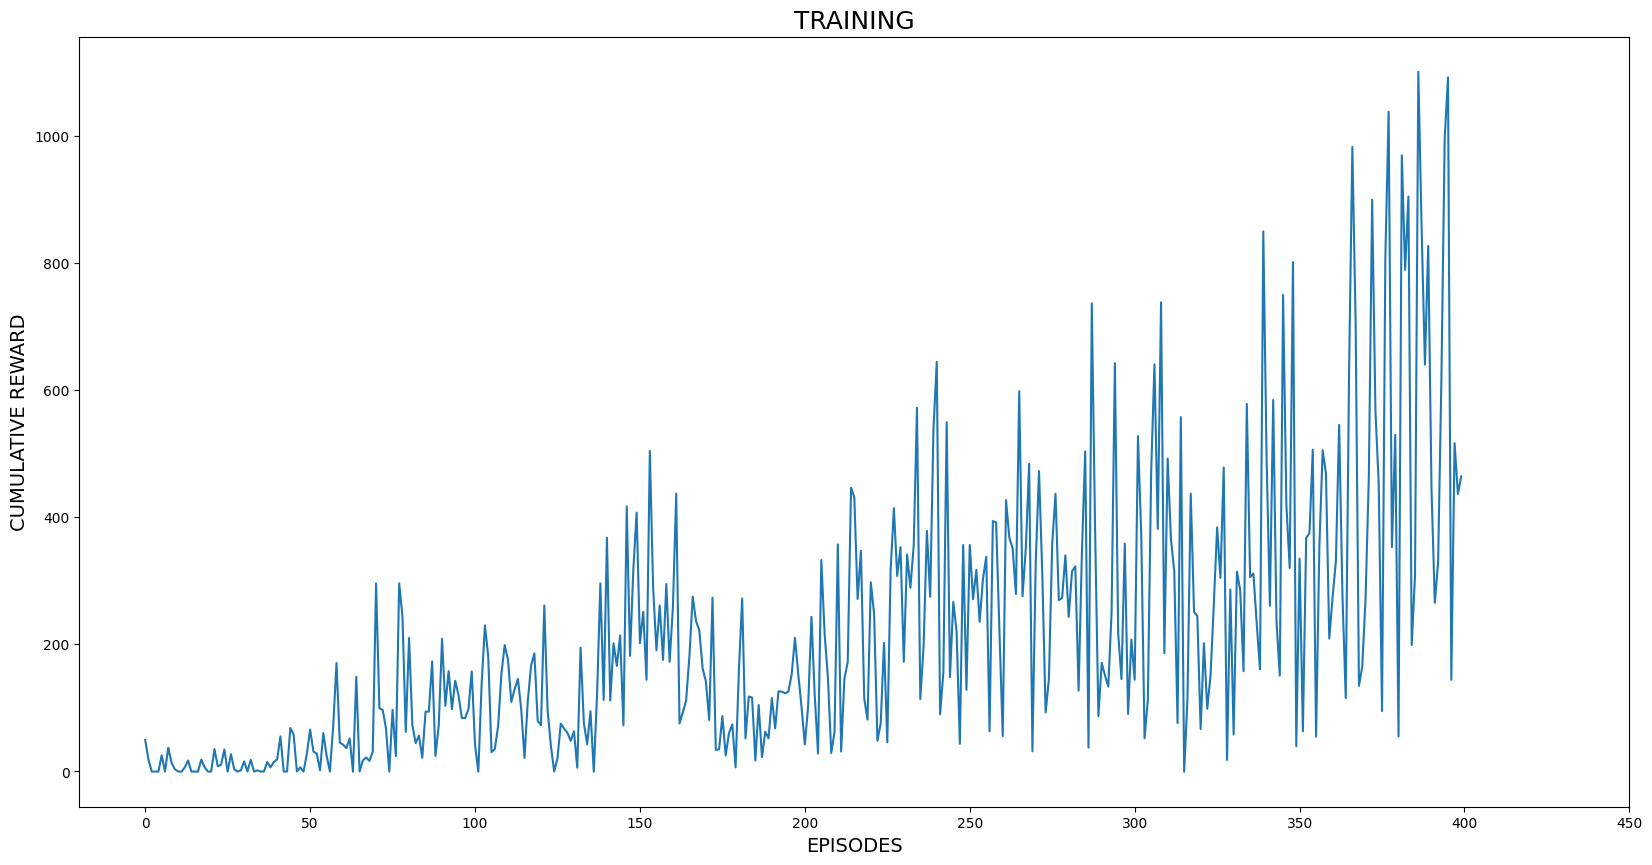

In [ ]:
#Results plotting

episodes = np.zeros(config.NUM_EPISODES, int)
for i in range (config.NUM_EPISODES):
    episodes[i] = i

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
#ax.plot(episodes, cum_reward_table, label="Q table policy")  # Plot some data on the axes.
ax.plot(episodes, cum_reward_nn)  # Plot some data on the axes.
ax.set_xlabel('EPISODES', fontsize=14)  # Add an x-label to the axes.
ax.set_ylabel('CUMULATIVE REWARD', fontsize=14)  # Add a y-label to the axes.
ax.set_title("TRAINING", fontsize=18)  # Add a title to the axes.
#ax.legend(loc=(0.3, -0.1))  # Add a legend.

plt.xticks(np.arange(0, 500, 50))            # np.arange(min,max, step)

#Save the image of plotting
plt.savefig('TrainingPlot.png')